# Neural Force Field for Excited States

This Jupyter Notebook contains an example of how to train a neural force field on two electronic states.

We first import all dependencies for this tutorial.

In [1]:
import sys
sys.path.append("../..")
sys.path.append("..")

import os
import shutil
import numpy as np
import matplotlib.pyplot as plt

import torch
from torch.optim import Adam
from torch.utils.data import DataLoader


from nff.data import Dataset, split_train_validation_test
import pickle
from nff.data.loader import collate_dicts

from nff.train import Trainer, get_trainer, get_model, loss, hooks, metrics, evaluate


We now set some parameters, including the output director and the GPU. We also can set the `DIABATIC` to true or false. If true, the neural network will produce three elements of the Hamiltonian and diagonalize it to give the adiabatic energies. If false, the neural network will simply produce the two adiabatic energies.

We also can choose whether to sort the outputted energies or not by setting `SORTED`. The ground state should always be lower in energy than the excited state, so we might want to enforce that by having torch always sort the outputs.

In [2]:
DIABATIC = False
SORTED = False

DEVICE = 0
OUTDIR = './sandbox_excited'

if os.path.exists(OUTDIR):
    newpath = os.path.join(os.path.dirname(OUTDIR), 'backup')
    if os.path.exists(newpath):
        shutil.rmtree(newpath)
        
    shutil.move(OUTDIR, newpath)
    

## Loading the relevant data

We can load the dataset in the regular way, from the example file `switch_demonstration.pth.tar`. This dataset contains a sample surface-hopping trajectory of the photoswitch fluoro-azobenzene. After loading the dataset we split it into training, validation and test sets.

In [3]:
dataset = Dataset.from_file("data/switch_demonstration.pth.tar")
train, val, test = split_train_validation_test(dataset, val_size=0.2, test_size=0.2)

In [4]:
train_loader = DataLoader(train, batch_size=50, collate_fn=collate_dicts)
val_loader = DataLoader(val, batch_size=50, collate_fn=collate_dicts)
test_loader = DataLoader(test, batch_size=50, collate_fn=collate_dicts)


## Creating a model

In NeuralFF we must specify the readout dictionary. This contains information about how the convolutions get turned into outputted properties. We can also specify a function called `post_readout`. This can act on the output of `readoutdict` to generate new properties.

In particular, if we set `DIABATIC` to true, then our `readoutdict` outputs diabatic energies 0 and 1, as well as a diabatic coupling lambda. Then our `post_readout` function converts these diabatic quantities to adiabatic energies. Note that we use a small non-zero value `EPS` when computing the square root function below. This is because the derivative of the square root function is undefined when its argument is zero. The `EPS` parameter keeps the argument away from zero. 

If we set `DIABATIC` to false, then `readoutdict` simply returns the adiabatic energies right away. If we set `SORTED` to true, then `post_readout` will sort the adiabatic energies. This ensures that the excited state always has higher energy than the ground state.

In [5]:
n_atom_basis = 256
EPS = 1e-15


if DIABATIC:
    readoutdict = {
                        "d0": [{'name': 'linear', 'param' : { 'in_features': n_atom_basis, 
                                                                  'out_features': int(n_atom_basis / 2)}},
                                   {'name': 'shifted_softplus', 'param': {}},
                                   {'name': 'linear', 'param' : { 'in_features': int(n_atom_basis / 2), 
                                                                  'out_features': 1}}],
                        "d1": [{'name': 'linear', 'param' : { 'in_features': n_atom_basis, 
                                                                  'out_features': int(n_atom_basis / 2)}},
                                   {'name': 'shifted_softplus', 'param': {}},
                                   {'name': 'linear', 'param' : { 'in_features': int(n_atom_basis / 2), 
                                                                  'out_features': 1}}],
        
                        "lambda": [{'name': 'linear', 'param' : { 'in_features': n_atom_basis, 
                                                                  'out_features': int(n_atom_basis / 2)}},
                                   {'name': 'shifted_softplus', 'param': {}},
                                   {'name': 'linear', 'param' : { 'in_features': int(n_atom_basis / 2), 
                                                                  'out_features': 1}}]
                    }
    
    def post_readout(predict_dict, readoutdict):
        d0 = predict_dict["d0"]
        d1 = predict_dict["d1"]
        lam = predict_dict["lambda"]
        
        e0 = 1.0/2.0*(d0 + d1 - torch.sqrt((d0-d1)**2 + 4*lam**2 + EPS) )
        e1 = 1.0/2.0*(d0 + d1 + torch.sqrt((d0-d1)**2 + 4*lam**2 + EPS) )
        dic = {"energy_0": e0, "energy_1": e1, "energy_d_0": d0, "energy_d_1": d1, "lambda": lam}
        return dic
    
else:
    
    readoutdict = {
                        "energy_0": [{'name': 'linear', 'param' : { 'in_features': n_atom_basis, 
                                                                  'out_features': int(n_atom_basis / 2)}},
                                   {'name': 'shifted_softplus', 'param': {}},
                                   {'name': 'linear', 'param' : { 'in_features': int(n_atom_basis / 2), 
                                                                  'out_features': 1}}],
                        "energy_1": [{'name': 'linear', 'param' : { 'in_features': n_atom_basis, 
                                                                  'out_features': int(n_atom_basis / 2)}},
                                   {'name': 'shifted_softplus', 'param': {}},
                                   {'name': 'linear', 'param' : { 'in_features': int(n_atom_basis / 2), 
                                                                  'out_features': 1}}]
                    }
    

    if SORTED:
        def post_readout(predict_dict, readoutdict):
            sorted_keys = sorted(list(readoutdict.keys()))
            sorted_ens = torch.sort(torch.stack([predict_dict[key] for key in sorted_keys]))[0] 
            sorted_dic = {key: val for key, val in zip(sorted_keys, sorted_ens)}
            return sorted_dic
    else:
        post_readout = None

        

params = {
    'n_atom_basis': n_atom_basis,
    'n_filters': 256,
    'n_gaussians': 32,
    'n_convolutions': 10,
    'cutoff': 5.0,
    'trainable_gauss': False, 
    'readoutdict': readoutdict,
    'post_readout': post_readout
}



model = get_model(params)

## Creating a trainer

We create a trainer and select an optimizer in the usual way:

In [6]:
rho_0 = 0.1
rho_1 = 0.1

loss_coef = {'energy_0': rho_0, 'energy_0_grad': 1, 'energy_1': rho_1, 'energy_1_grad': 1}
loss_fn = loss.build_mse_loss(loss_coef=loss_coef)

trainable_params = filter(lambda p: p.requires_grad, model.parameters())
optimizer = Adam(trainable_params, lr=3e-4)

### Metrics and hooks

Metrics and hooks are set up in the same way as for one state:

In [7]:
train_metrics = [
    metrics.MeanAbsoluteError('energy_0'),
    metrics.MeanAbsoluteError('energy_0_grad'),
    metrics.MeanAbsoluteError('energy_1'),
    metrics.MeanAbsoluteError('energy_1_grad'),

]

In [8]:
train_hooks = [
    hooks.MaxEpochHook(1000),
    hooks.CSVHook(
        OUTDIR,
        metrics=train_metrics,
    ),
    hooks.PrintingHook(
        OUTDIR,
        metrics=train_metrics,
        separator = ' | '
    ),
    hooks.ReduceLROnPlateauHook(
        optimizer=optimizer,
        patience=30,
        factor=0.5,
        min_lr=1e-7,
        window_length=1,
        stop_after_min=True
    )
]

### Trainer wrapper

The training wrapper is the same as usual:

In [9]:
T = Trainer(
        model_path=OUTDIR,
        model=model,
        loss_fn=loss_fn,
        optimizer=optimizer,
        train_loader=train_loader,
        validation_loader=val_loader,
        checkpoint_interval=1,
        hooks=train_hooks
    )

Now we can finally train the model using the method `train` from the `Trainer`:

In [10]:
T.train(device=DEVICE, n_epochs=3)

               Time | Epoch | Learning rate | Train loss | Validation loss | MAE_energy_0 | MAE_energy_0_grad | MAE_energy_1 | MAE_energy_1_grad | GPU Memory (MB)
2019-11-22 16:30:25 |     1 |     3.000e-04 |     0.0000 |      11343.2422 |     157.4003 |           34.8225 |     139.2168 |           34.3931 |            3428
2019-11-22 16:30:25 |     2 |     3.000e-04 |     0.0000 |      10912.9697 |     153.1194 |           34.6334 |     137.1383 |           34.1926 |            3428
2019-11-22 16:30:26 |     3 |     3.000e-04 |     0.0000 |      10486.5664 |     149.2656 |           34.7334 |     132.0967 |           34.3629 |            3428


## Evaluating the model on the test set

Now we have a brand new model trained and validated. We can use the best model from this training to evaluate its performance on the test set. `results` contains the predictions of properties for the whole test dataset. `targets` contains the ground truth for such data. `test_loss` is the loss, calculated with the same function used during the training part

In [11]:
results, targets, val_loss = evaluate(model, test_loader, loss_fn, device=DEVICE)

Finally, we can plot our results to observe how well is our model performing:

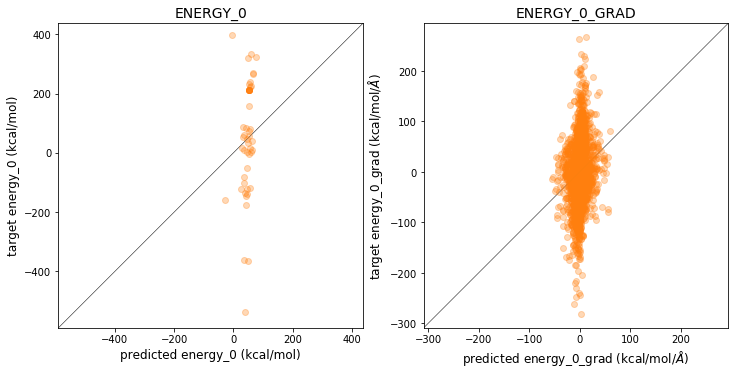

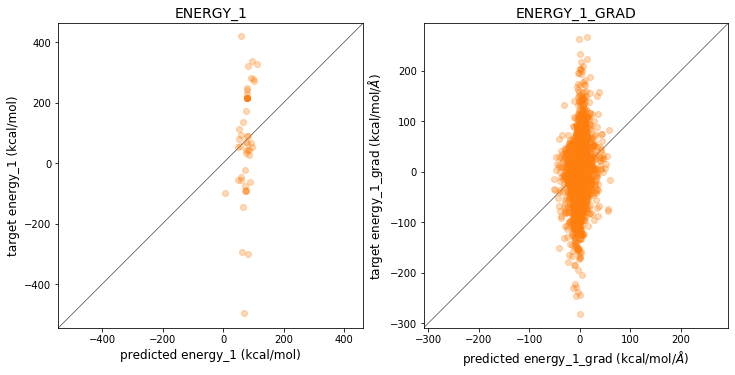

In [12]:
import pdb

units = {
    'energy_0_grad': r'kcal/mol/$\AA$',
    'energy_0': 'kcal/mol',
    'energy_1_grad': r'kcal/mol/$\AA$',
    'energy_1': 'kcal/mol'
}

dic_keys = list(loss_coef.keys())

for i in range(int(len(dic_keys)/2) ):
    
    fig, ax_fig = plt.subplots(1, 2, figsize=(12, 6))

    for ax, key in zip(ax_fig, dic_keys[2*i:2*i+2] ):

        pred = torch.stack(results[key]).reshape(-1).cpu().detach().numpy()
        targ = torch.stack(targets[key]).reshape(-1).cpu().detach().numpy()

        ax.scatter(pred, targ, color='#ff7f0e', alpha=0.3)

        lim_min = min(np.min(pred), np.min(targ)) * 1.1
        lim_max = max(np.max(pred), np.max(targ)) * 1.1

        ax.set_xlim(lim_min, lim_max)
        ax.set_ylim(lim_min, lim_max)
        ax.set_aspect('equal')

        ax.plot((lim_min, lim_max),
                (lim_min, lim_max),
                color='#000000',
                zorder=-1,
                linewidth=0.5)

        ax.set_title(key.upper(), fontsize=14)
        ax.set_xlabel('predicted %s (%s)' % (key, units[key]), fontsize=12)
        ax.set_ylabel('target %s (%s)' % (key, units[key]), fontsize=12)

    plt.show()

The model isn't doing that well yet because we've only used 100 geometries. It would do better with more!